In [1]:
"""
@author: Victor Michel-Dansac
"""

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %cd /content
    !rm -rf /content/DG-PINNs
    !git clone https://github.com/Victor-MichelDansac/DG-PINNs.git
    %cd /content/DG-PINNs


## Approximately well-balanced Discontinuous Galerkin methods using bases enriched with Physics-Informed Neural Networks

This notebook aims at replicating some experiments from the article entitled `Approximately well-balanced Discontinuous Galerkin methods using bases enriched with Physics-Informed Neural Networks`, by Emmanuel Franck (<emmanuel.franck@inria.fr>), Victor Michel-Dansac (<victor.michel-dansac@inria.fr>) and Laurent Navoret (<laurent.navoret@math.unistra.fr>).

The problem under consideration is the advection equation with source term, with velocity $c = 1$:
$$
    \frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = a u + b u^2.
$$
The unknown function is $u : \mathbb{R}^+ \times \mathbb{R} \to \mathbb{R}$, which depends on the time variable $t \geq 0$ and the space variable $x$.

The space domain is $x \in (0, 1)$, and the system parameters are:
- $a \in (0.5, 1)$, 
- $b \in (0.5, 1)$, 
- $u_0 \in (0.1, 0.2)$ the left boundary condtion: $u(t, 0) = u_0$ for all $t \geq 0$.

In [2]:
# necessary imports and pytorch setup

import os

import DG_scheme
import matplotlib.pyplot as plt
import torch
from mesh import Mesh, run_and_plot, run_perturbation_analysis
from model import Network
from torch.autograd import grad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")

torch.set_default_dtype(torch.double)
torch.set_default_device(device)

torch loaded; device is cpu


### 1/ PINN training

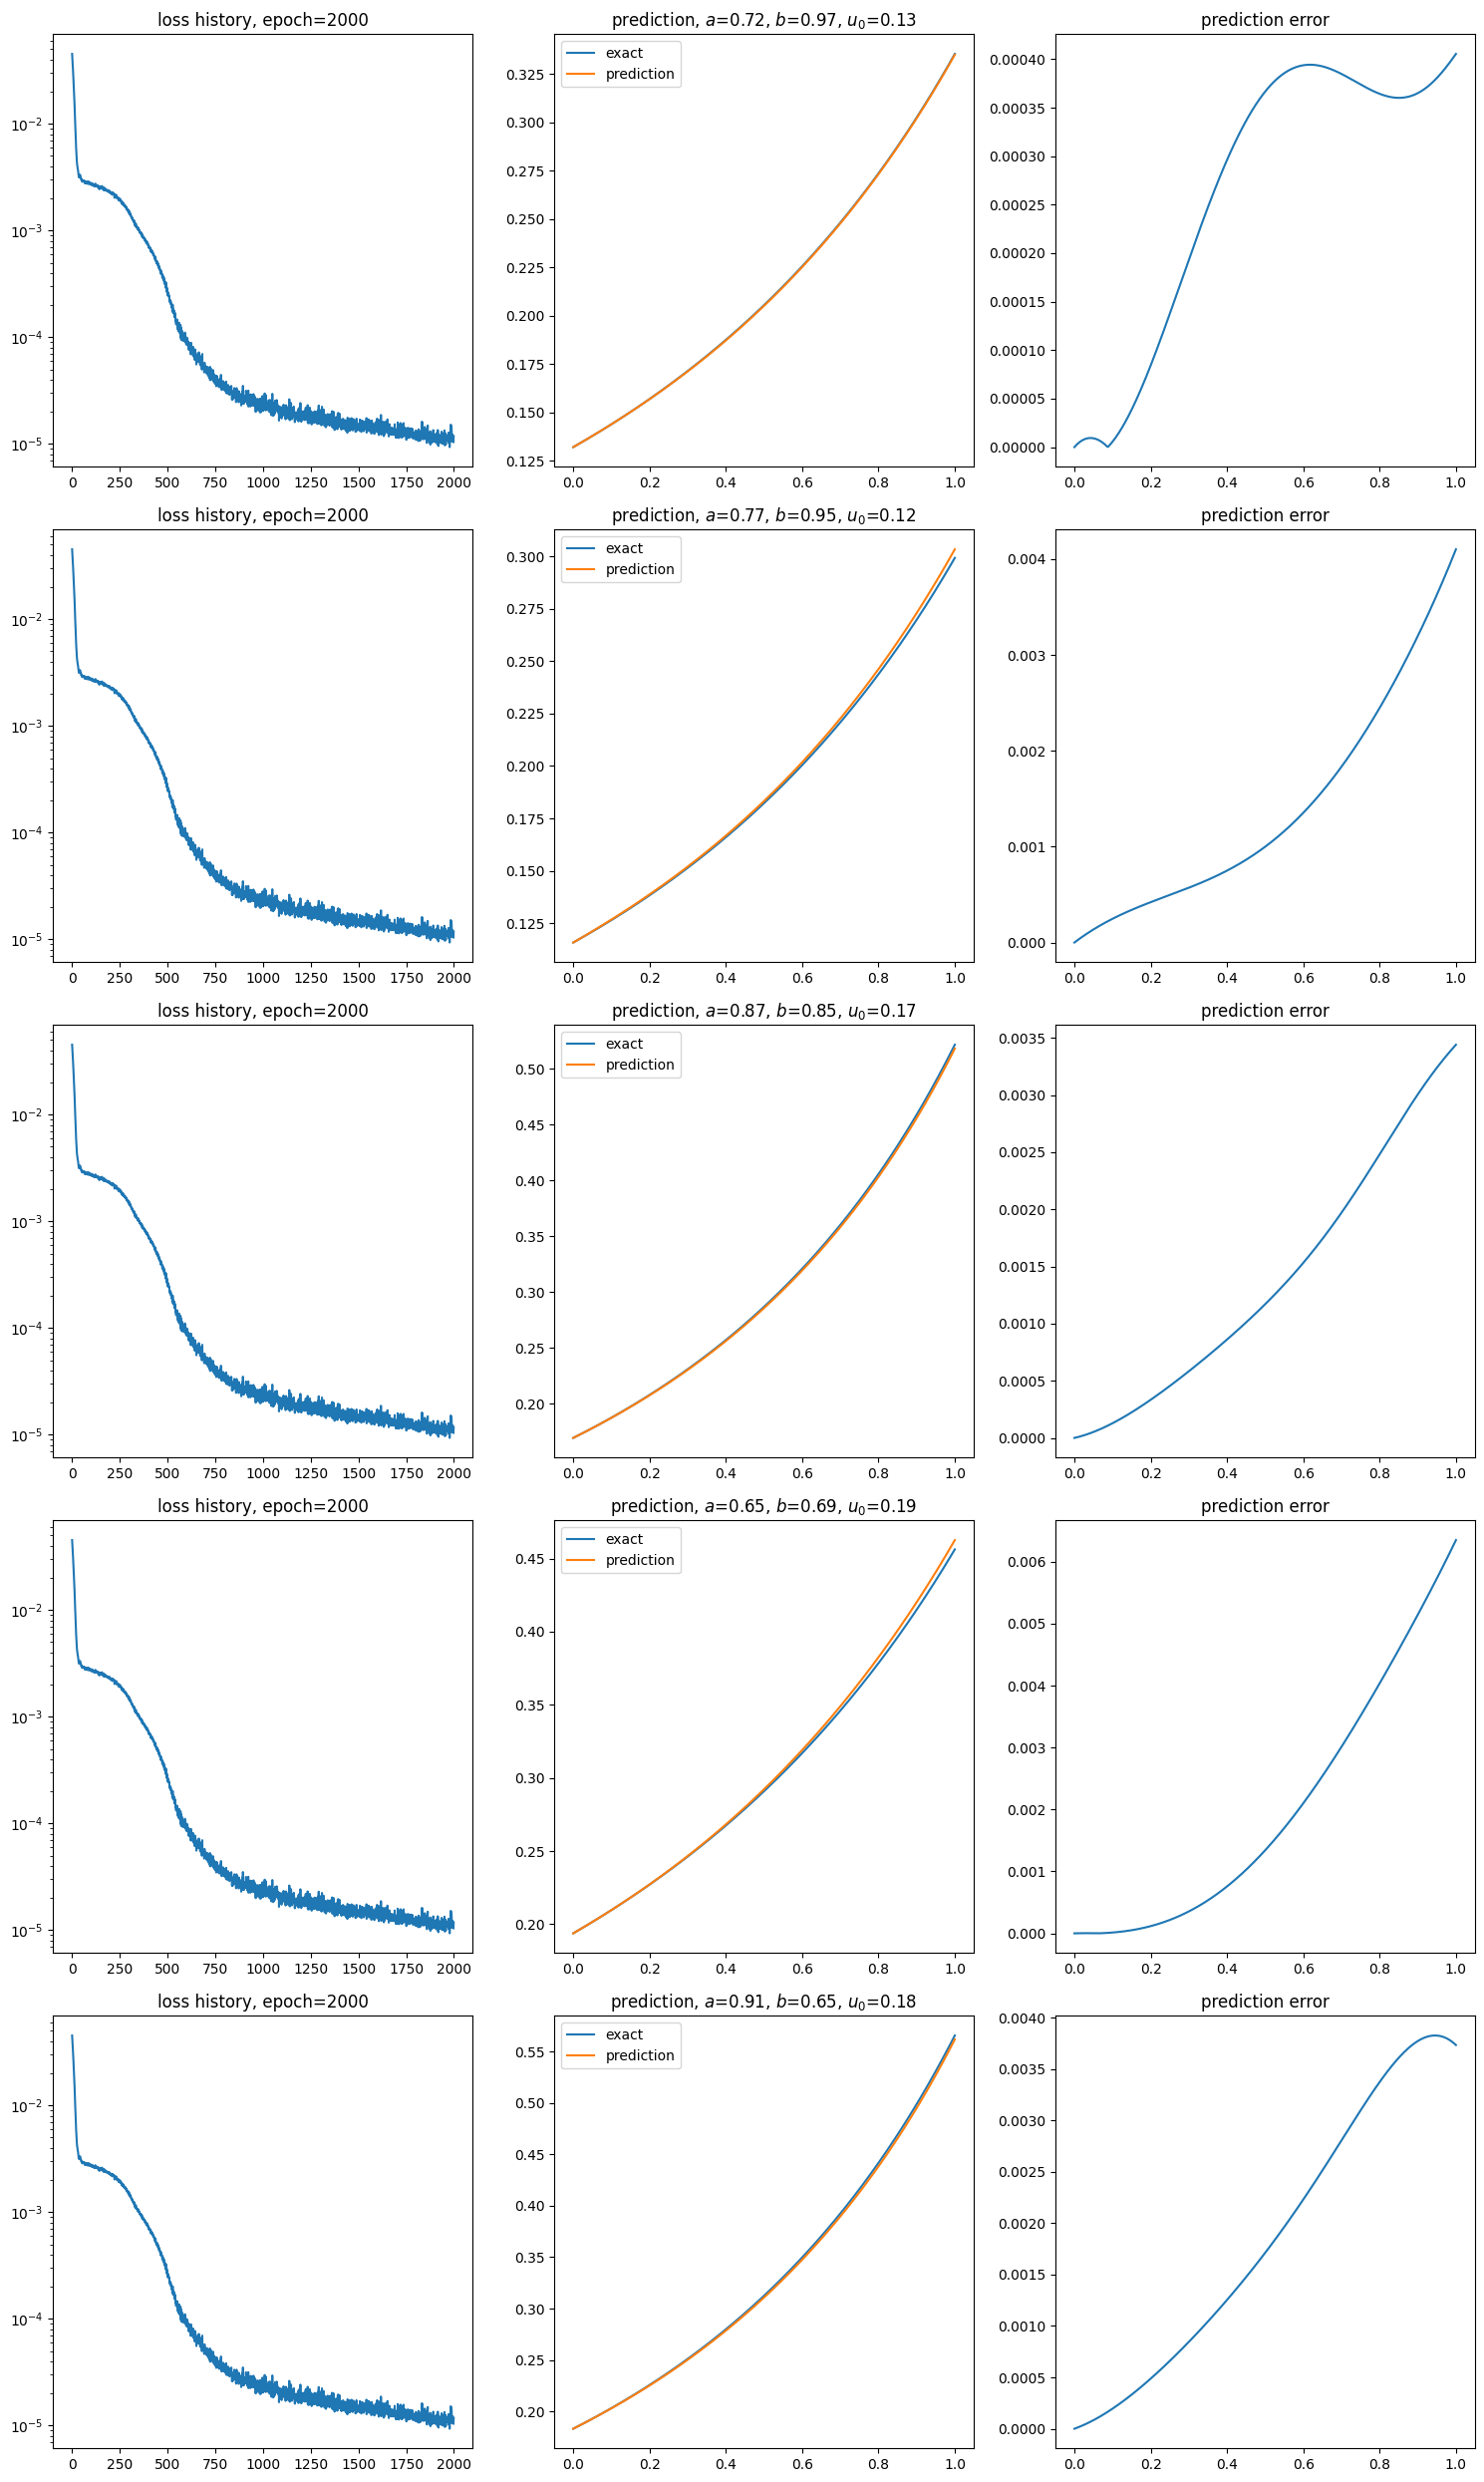

In [3]:
train = True  # trains the model
# train = False  # uses the trained model (only available after training)

if train:
    # new_training = False  # restarts training with the existing trained model
    new_training = True  # deletes the existing model and start a new training

    if new_training:
        try:
            os.remove(Network.DEFAULT_FILE_NAME)
        except FileNotFoundError:
            pass

    model = Network()

    n_epochs = 500  # number of epochs
    n_collocation = 10_000  # number of collocation points (for the PDE loss)
    n_data = 0  # number of data points (for the data loss)
    model.train(n_epochs=n_epochs, n_collocation=n_collocation, n_data=n_data)

else:
    model = Network()
    model.plot_result(random=True, n_plots=5)


### 2/ Discontinuous Galerkin basis functions with prior

Once the model has been satisfactorily trained (say, once the value of the loss function is lower than $10^{-5}$), one can add it as a prior to the DG scheme.

                           no_prior,  error =  3.018e-06
                          CPU times:  meshing =  5.95e-02
                          CPU times:   scheme =  1.28e+00
                          CPU times:    total =  1.28e+00

                with_prior_additive,  error =  8.751e-08
                          CPU times:  meshing =  3.15e-02
                          CPU times:   scheme =  1.30e+00
                          CPU times:    total =  1.30e+00



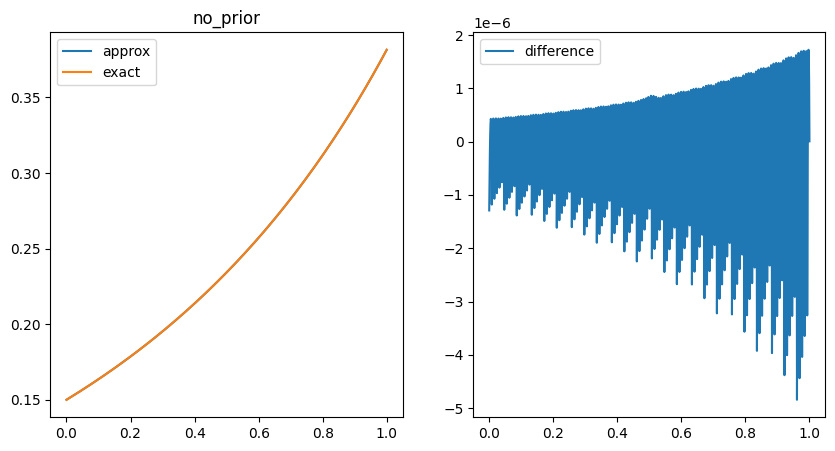

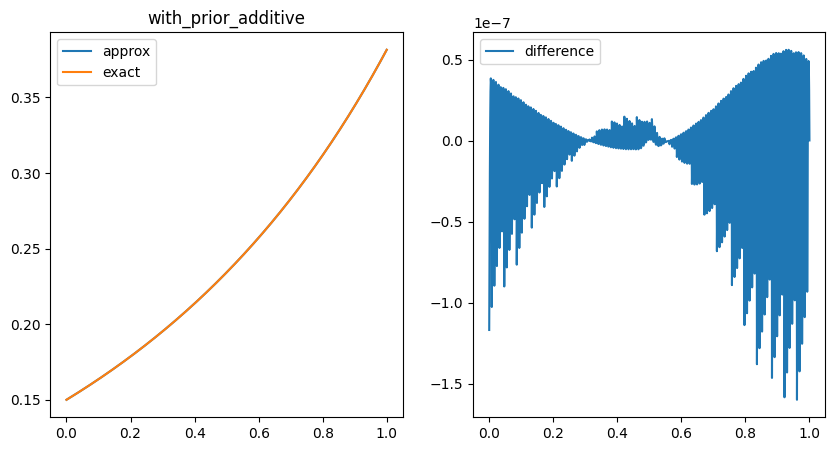

In [4]:
# choose the basis categories you wish to test
categories = [
    "no_prior",
    "with_prior_additive",
    # "with_prior_multiplicative",
]

# perturbed_initial_condition = True  # runs a perturbation analysis
perturbed_initial_condition = False  # check the scheme output

# in both cases, available optional arguments are:
#   nx, integer, the number of space points
#   nG, integer, the number of basis function
#   source, bool, whether to add the source term
#   end_time, float, the final computation time

if perturbed_initial_condition:
    run_perturbation_analysis(categories)
else:
    source = True  # approximation of a steady solution
    # source = False  # pure advection of a Gaussian bump
    end_time = 0.5 if source else 1  # final physical time
    run_and_plot(categories, source=source, end_time=end_time, nx=128, nG=2)
